In [1]:
! rm -rf *

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"klausx3","key":"f152c4e63afb830348afbe87d30e7655"}'}

In [3]:
! pip install -q kaggle
! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

100% 1.49G/1.49G [00:50<00:00, 36.6MB/s]
100% 1.49G/1.49G [00:50<00:00, 32.0MB/s]


In [ ]:
!mkdir images
# !mv defocused_blurred images
# !mv motion_blurred images
# !mv sharp images

In [5]:
import os
import shutil
import random

# Define the paths to the original folders
defocused_folder = '/content/defocused_blurred'
motion_folder = '/content/motion_blurred'

# Define the path to the new folder
blur_folder = '/content/blur'

# Create the new folder if it does not exist
if not os.path.exists(blur_folder):
    os.mkdir(blur_folder)

# Randomly select 175 images from each of the original folders
defocused_images = random.sample(os.listdir(defocused_folder), 175)
motion_images = random.sample(os.listdir(motion_folder), 175)

# Copy the selected images to the new folder
for filename in defocused_images:
    shutil.copy(os.path.join(defocused_folder, filename), os.path.join(blur_folder, filename))

for filename in motion_images:
    shutil.copy(os.path.join(motion_folder, filename), os.path.join(blur_folder, filename))


In [7]:
import cv2
import os
import random

# Define the paths to the original and new folders
sharp_folder = '/content/sharp'
torch_folder = '/content/torch'

# Set the range of values for overexposure
min_torch = 1.5
max_torch = 2.5

# Create the new folder if it does not exist
if not os.path.exists(torch_folder):
    os.mkdir(torch_folder)

# Loop through each file in the sharp folder
for filename in os.listdir(sharp_folder):
    # Read the image
    image = cv2.imread(os.path.join(sharp_folder, filename))
    # Apply a random overexposure value
    torch_value = random.uniform(min_torch, max_torch)
    torch_image = cv2.addWeighted(image, torch_value, image, 0, 0)
    # Save the overexposed image to the torch folder
    cv2.imwrite(os.path.join(torch_folder, filename), torch_image)


In [8]:
!mkdir /content/images
!mv torch images
!mv blur images
!mv sharp images

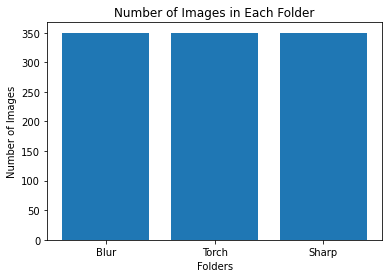

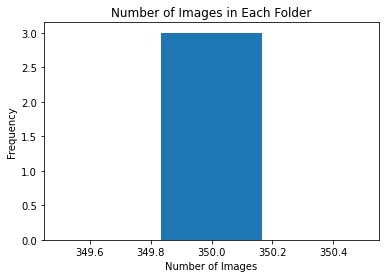

In [10]:
import matplotlib.pyplot as plt

# Define the directory path
dir_path = '/content/images'

# Get the number of images in each folder
blur_num = len(os.listdir(os.path.join(dir_path, 'blur')))
torch_num = len(os.listdir(os.path.join(dir_path, 'torch')))
sharp_num = len(os.listdir(os.path.join(dir_path, 'sharp')))

# Create a bar chart of the number of images in each folder
labels = ['Blur', 'Torch', 'Sharp']
values = [blur_num, torch_num, sharp_num]
plt.bar(labels, values)
plt.title('Number of Images in Each Folder')
plt.xlabel('Folders')
plt.ylabel('Number of Images')
plt.show()

# Create a histogram of the number of images in each folder
plt.hist([blur_num, torch_num, sharp_num], bins=3)
plt.title('Number of Images in Each Folder')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.show()


In [11]:
%%capture

! pip install transformers pytorch-lightning --quiet

In [12]:
import math
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

## Init Dataset and Split into Training and Validation Sets


In [13]:
data_dir = Path('images')

In [14]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

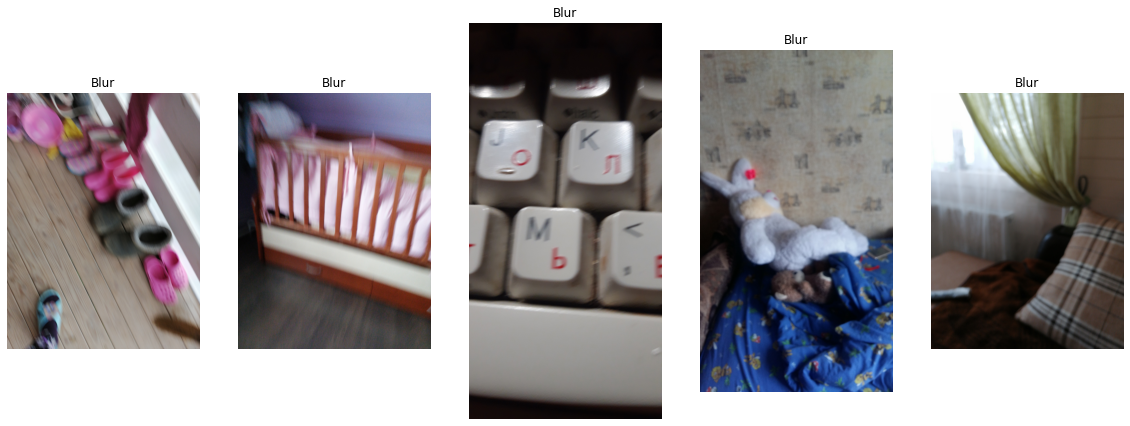

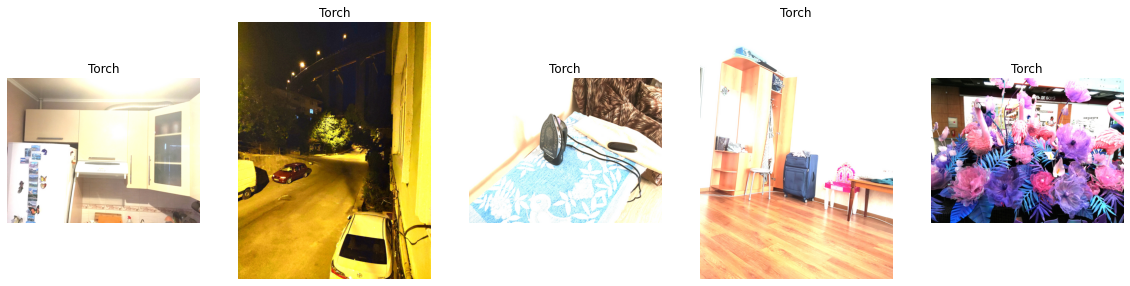

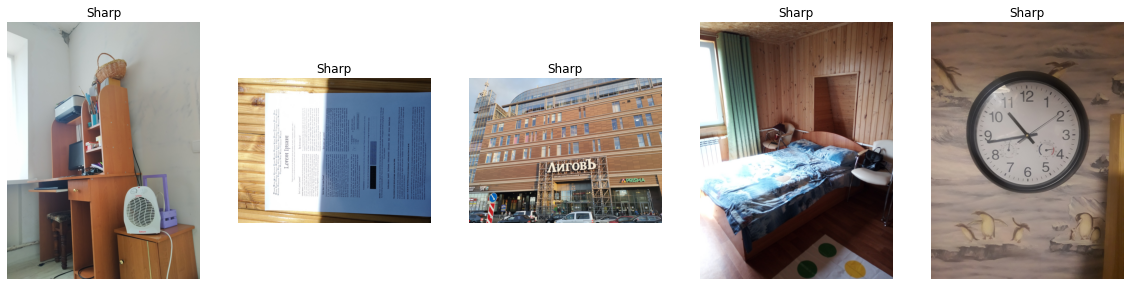

In [27]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
# Define the paths to the folders
blur_folder = Path('/content/images/blur')
torch_folder = Path('/content/images/torch')
sharp_folder = Path('/content/images/sharp')

# Create a list of tuples, where each tuple contains the folder path and the class name
folders = [(blur_folder, 'Blur'), (torch_folder, 'Torch'), (sharp_folder, 'Sharp')]

# Set the number of example images to show for each class
num_examples_per_class = 5

# Loop over the folders and create a separate plot for each class
for folder, class_name in folders:
    # Get a list of all the image files in the folder
    image_files = sorted([file for file in folder.iterdir() if file.is_file() and file.suffix in {'.jpg', '.png'}])
    
    # Take a random sample of the image files
    sample_files = np.random.choice(image_files, size=num_examples_per_class, replace=False)
    
    # Create a new figure
    plt.figure(figsize=(20,10))
    
    # Loop over the sample files and add them to the plot
    for i, file in enumerate(sample_files):
        # Load the image
        image = Image.open(file)
        
        # Create a new subplot
        plt.subplot(1, num_examples_per_class, i+1)
        
        # Show the image
        plt.imshow(image)
        
        # Set the title to the class name
        plt.title(class_name)
        
        # Turn off the axis
        plt.axis('off')
    
    # Show the plot
    plt.show()


## Preparing Labels for Our Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [28]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [29]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

## Init Feature Extractor, Model, Data Loaders


In [30]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [31]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [32]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=16)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | MulticlassAccuracy        | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
171.602   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


In [33]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])



Preds:  tensor([0, 2, 0, 1, 1, 1, 2, 0])
Labels: tensor([0, 2, 0, 1, 1, 1, 2, 0])


In [34]:
# save the model
model_dir = "./"
model_name = "vit_model"
model.save_pretrained(model_dir + model_name)


In [37]:
from PIL import Image

# Load the saved model
model_dir = "./"
model_name = "vit_model"
loaded_model = ViTForImageClassification.from_pretrained(model_dir + model_name)

# Load and preprocess the image
image_path = "/content/blurr.jpg"
image = Image.open(image_path)
inputs = feature_extractor(image, return_tensors="pt")

# Make the prediction
outputs = loaded_model(**inputs)
predicted_class = id2label[str(outputs.logits.argmax(1).item())]

print(f"Predicted class: {predicted_class}")


Predicted class: blur


In [38]:
 !zip -r model.zip /content/vit_model

  adding: content/vit_model/ (stored 0%)
  adding: content/vit_model/pytorch_model.bin (deflated 7%)
  adding: content/vit_model/config.json (deflated 48%)
